In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import het_arch, acorr_ljungbox
from statsmodels.stats.stattools import durbin_watson, jarque_bera
import warnings
from itertools import combinations
from arch import arch_model
from statsmodels.tsa.stattools import adfuller

# Konfiguracja
warnings.filterwarnings("ignore")
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

POBIERANIE DANYCH


[*********************100%***********************]  3 of 3 completed


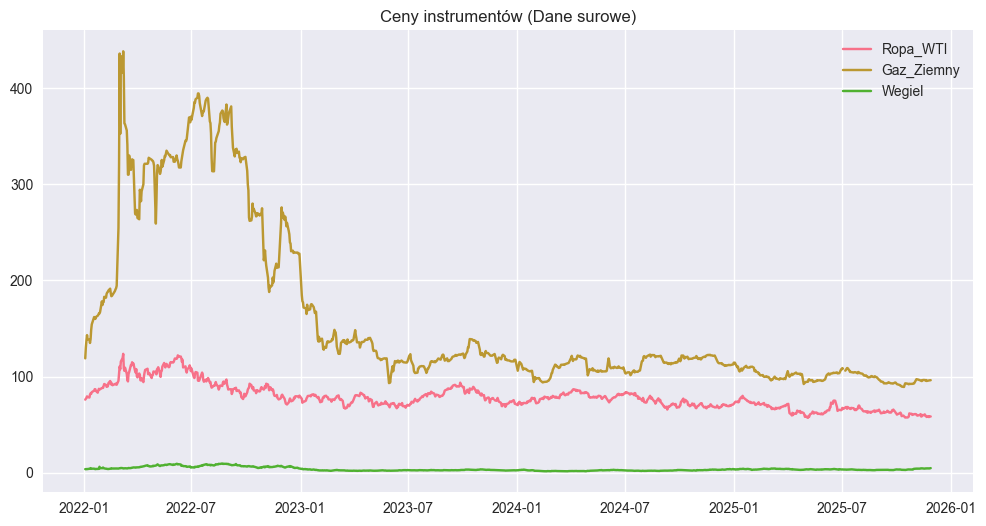

In [ ]:
print("POBIERANIE DANYCH")

tickers = ['CL=F', 'NG=F', 'MTF=F']
names = ['Ropa_WTI', 'Gaz_Ziemny', 'Wegiel']

# Pobieranie danych
data = yf.download(
    tickers,
    start='2022-01-01',
    end='2025-12-01',
    auto_adjust=False,
    threads=False,
    timeout=20
)['Adj Close']

# Nadanie czytelnych nazw kolumn
data.columns = names

# Wizualizacja cen (Niestacjonarne)
plt.figure(figsize=(12, 6))
for col in data.columns:
    plt.plot(data[col], label=col)
plt.title('Ceny instrumentów (Dane surowe)')
plt.legend()
plt.show()

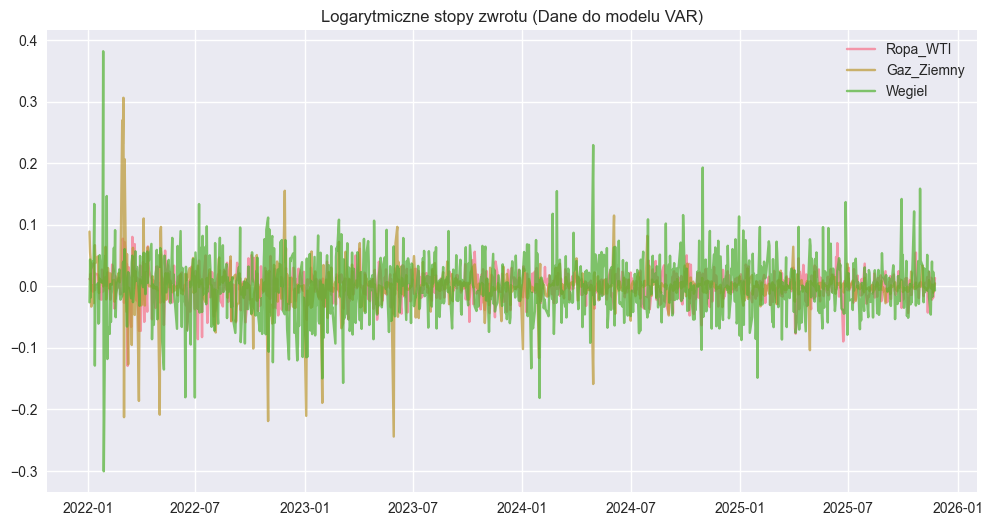


Podgląd danych (Log-zwroty):
            Ropa_WTI  Gaz_Ziemny    Wegiel
Date                                      
2022-01-04  0.011890    0.088796 -0.026024
2022-01-05  0.011108    0.054977  0.043434
2022-01-06  0.020470    0.040997 -0.018196
2022-01-07 -0.007072   -0.033023  0.026917
2022-01-10 -0.008528    0.001803  0.040781


In [ ]:
df_ret = np.log(data / data.shift(1)).dropna()

# Wizualizacja stóp zwrotu (Stacjonarne)
plt.figure(figsize=(12, 6))
for col in df_ret.columns:
    plt.plot(df_ret[col], alpha=0.7, label=col)
plt.title('Logarytmiczne stopy zwrotu (Dane do modelu VAR)')
plt.legend()
plt.show()

print("\nPodgląd danych (Log-zwroty):")
print(df_ret.head())


ANALIZA EKSPLORACYJNA (EDA)

Statystyki opisowe log-zwrotów:
                mean       std       min       max      skew   kurtosis
Ropa_WTI   -0.000256  0.023176 -0.129267  0.080237 -0.426240   1.836552
Gaz_Ziemny -0.000206  0.033143 -0.244091  0.306201  0.081901  28.061530
Wegiel      0.000194  0.050281 -0.300480  0.381727  0.267480   5.319280


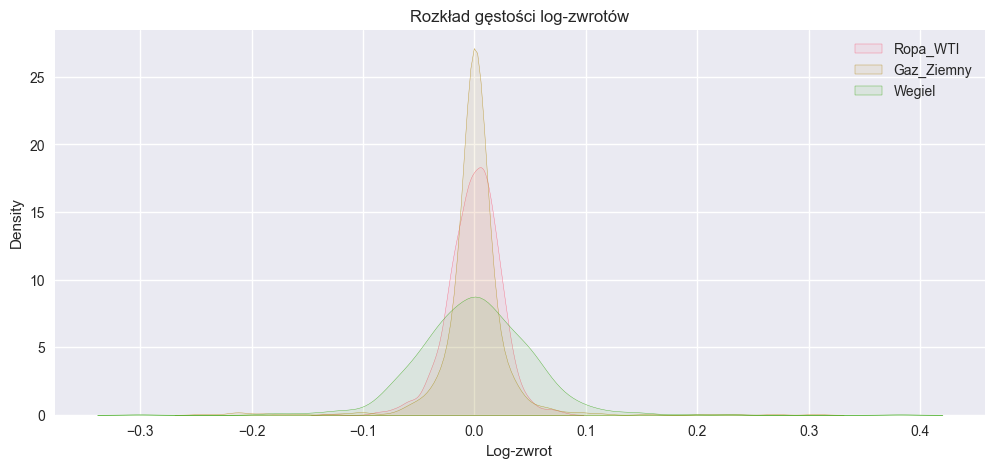

In [ ]:
print("\nANALIZA EKSPLORACYJNA (EDA)")

# Statystyki opisowe
desc_stats = df_ret.describe().T
desc_stats['skew'] = df_ret.skew()
desc_stats['kurtosis'] = df_ret.kurtosis()
print("\nStatystyki opisowe log-zwrotów:")
print(desc_stats[['mean', 'std', 'min', 'max', 'skew', 'kurtosis']])

# Wykresy gęstości (Density Plots)
plt.figure(figsize=(12, 5))
for col in df_ret.columns:
    sns.kdeplot(df_ret[col], label=col, fill=True, alpha=0.1)
plt.title('Rozkład gęstości log-zwrotów')
plt.xlabel('Log-zwrot')
plt.legend()
plt.show()

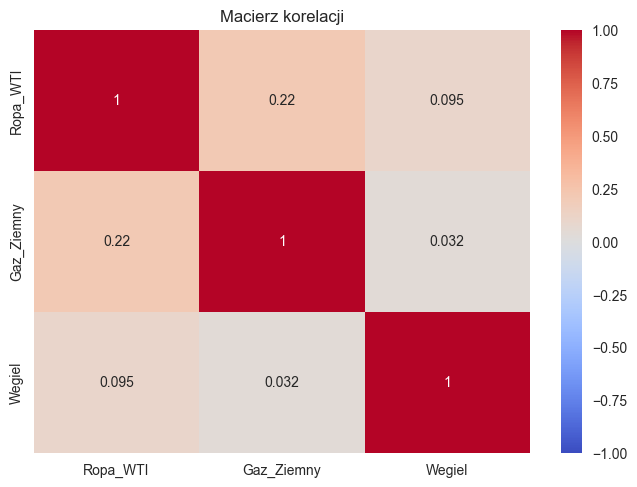

In [ ]:
corr_matrix = df_ret.corr()
plot = sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Macierz korelacji')
plt.show()

In [ ]:
print("\nTESTY STACJONARNOŚCI")
stationary = True
for col in df_ret.columns:
    res = adfuller(df_ret[col])
    print(f"Zmienna: {col:12} | ADF Stat: {res[0]:.4f} | p-value: {res[1]:.4f}")
    if res[1] > 0.05:
        print(f"UWAGA: Zmienna {col} może być niestacjonarna!")
        stationary = False

if stationary:
    print("-> Wszystkie zmienne są stacjonarne (I(0)). Można budować VAR.")
else:
    print("-> Wykryto niestacjonarność. Należy rozważyć inne przekształcenie.")


TESTY STACJONARNOŚCI
Zmienna: Ropa_WTI     | ADF Stat: -12.7680 | p-value: 0.0000
Zmienna: Gaz_Ziemny   | ADF Stat: -7.8848 | p-value: 0.0000
Zmienna: Wegiel       | ADF Stat: -35.7944 | p-value: 0.0000
-> Wszystkie zmienne są stacjonarne (I(0)). Można budować VAR.


In [ ]:
print("\nESTYMACJA MODELU VAR")
model = VAR(df_ret)

lag_selection = model.select_order(maxlags=15)
print(lag_selection.summary())
optimal_lag = lag_selection.aic
print(f"\nWybrano rząd opóźnień p = {optimal_lag} na podstawie AIC.")

# Estymacja
results = model.fit(optimal_lag)
print(results.summary())
is_stable = results.is_stable()
print(f"\nCzy model VAR jest stabilny? {is_stable}")
if not is_stable:
    print("UWAGA: Model niestabilny! Analiza IRF/FEVD może być błędna.")


ESTYMACJA MODELU VAR
 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -20.39     -20.37*   1.402e-09     -20.38*
1       -20.40      -20.34   1.384e-09      -20.38
2      -20.40*      -20.30  1.375e-09*      -20.36
3       -20.40      -20.25   1.382e-09      -20.34
4       -20.40      -20.20   1.386e-09      -20.32
5       -20.39      -20.15   1.389e-09      -20.30
6       -20.40      -20.11   1.381e-09      -20.29
7       -20.39      -20.06   1.390e-09      -20.27
8       -20.38      -20.00   1.405e-09      -20.24
9       -20.39      -19.96   1.396e-09      -20.23
10      -20.38      -19.91   1.412e-09      -20.20
11      -20.38      -19.86   1.414e-09      -20.18
12      -20.37      -19.80   1.428e-09      -20.15
13      -20.35      -19.74   1.450e-09      -20.12
14      -20.35      -19.69   1.459e-09      -20.10
15      -20.34      -19.64   1.470e-09      -20.07
---------

In [ ]:

residuals = results.resid

print("\n--- Test autokorelacji (Ljung-Box, lag=10) ---")
for col in residuals.columns:
    lb_test = acorr_ljungbox(residuals[col], lags=[10], return_df=True)
    print(f"Zmienna: {col}")
    print(lb_test)
    print("-" * 30)

print("\n--- Test normalności (Jarque-Bera) ---")
for col in residuals.columns:
    jb_stat, jb_pval = stats.jarque_bera(residuals[col])
    print(f"{col:12} | JB Stat: {jb_stat:.2f} | p-val: {jb_pval:.4f} -> {'Normalny' if jb_pval > 0.05 else 'Nienormalny'}")

print("\n--- Test na efekt ARCH (Engle's Test) ---")
arch_present = False
for col in residuals.columns:
    arch_test = het_arch(residuals[col])
    print(f"{col:12} | LM Stat: {arch_test[0]:.2f} | p-val: {arch_test[1]:.4f}")
    if arch_test[1] < 0.05:
        arch_present = True

if arch_present:
    print("\n[Wniosek]: Wykryto warunkową heteroskedastyczność (efekt ARCH).")
else:
    print("\n[Wniosek]: Brak silnych efektów ARCH.")


--- Test autokorelacji (Ljung-Box, lag=10) ---
Zmienna: Ropa_WTI
      lb_stat  lb_pvalue
10  23.729836   0.008351
------------------------------
Zmienna: Gaz_Ziemny
      lb_stat  lb_pvalue
10  21.654472   0.016965
------------------------------
Zmienna: Wegiel
     lb_stat  lb_pvalue
10  9.026075   0.529631
------------------------------

--- Test normalności (Jarque-Bera) ---
Ropa_WTI     | JB Stat: 151.83 | p-val: 0.0000 -> Nienormalny
Gaz_Ziemny   | JB Stat: 28687.67 | p-val: 0.0000 -> Nienormalny
Wegiel       | JB Stat: 1085.55 | p-val: 0.0000 -> Nienormalny

--- Test na efekt ARCH (Engle's Test) ---
Ropa_WTI     | LM Stat: 104.44 | p-val: 0.0000
Gaz_Ziemny   | LM Stat: 210.02 | p-val: 0.0000
Wegiel       | LM Stat: 58.52 | p-val: 0.0000

[Wniosek]: Wykryto warunkową heteroskedastyczność (efekt ARCH).


In [ ]:
print("\ESTYMACJA MODELI GARCH(1,1) NA RESZTACH")

garch_results = {}
conditional_volatility = pd.DataFrame(index=residuals.index)

for col in names:
    print(f"\n--- Estymacja GARCH(1,1) dla: {col} ---")
    garch_model_spec = arch_model(residuals[col], vol='Garch', p=1, q=1, mean='Zero', dist='t')

    res_garch = garch_model_spec.fit(disp='off')

    garch_results[col] = res_garch
    conditional_volatility[col] = res_garch.conditional_volatility

    print(res_garch.summary())

\ESTYMACJA MODELI GARCH(1,1) NA RESZTACH

--- Estymacja GARCH(1,1) dla: Ropa_WTI ---
                          Zero Mean - GARCH Model Results                           
Dep. Variable:                     Ropa_WTI   R-squared:                       0.000
Mean Model:                       Zero Mean   Adj. R-squared:                  0.001
Vol Model:                            GARCH   Log-Likelihood:                2350.73
Distribution:      Standardized Student's t   AIC:                          -4693.46
Method:                  Maximum Likelihood   BIC:                          -4673.93
                                              No. Observations:                  974
Date:                      Thu, Dec 04 2025   Df Residuals:                      974
Time:                              16:35:47   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. I

In [ ]:
print("\n=== 5. DIAGNOSTYKA KOŃCOWA (CZY GARCH USUNĄŁ EFEKT ARCH?) ===")
std_resid = pd.DataFrame()
for col in names:
    std_resid[col] = residuals[col] / conditional_volatility[col]

print("\nTest mnożnika Lagrange'a (ARCH-LM) na resztach standaryzowanych:")
print(f"{'Zmienna':<15} | {'p-value (H0: brak ARCH)':<25} | {'Wniosek'}")
print("-" * 55)

for col in names:
    arch_test = het_arch(std_resid[col])
    pval = arch_test[1]
    wniosek = "OK (Brak ARCH)" if pval > 0.05 else "Nadal występuje ARCH"
    print(f"{col:<15} | {pval:.4f}                    | {wniosek}")


=== 5. DIAGNOSTYKA KOŃCOWA (CZY GARCH USUNĄŁ EFEKT ARCH?) ===

Test mnożnika Lagrange'a (ARCH-LM) na resztach standaryzowanych:
Zmienna         | p-value (H0: brak ARCH)   | Wniosek
-------------------------------------------------------
Ropa_WTI        | 0.3955                    | OK (Brak ARCH)
Gaz_Ziemny      | 0.9975                    | OK (Brak ARCH)
Wegiel          | 0.9623                    | OK (Brak ARCH)


In [ ]:
def get_robust_granger_pvalue(data, caused_var, causing_var, lags):
    """
    Oblicza p-value dla testu przyczynowości Grangera używając
    odpornych błędów standardowych (HC0) w procedurze OLS.
    """
    # 1. Tworzenie lagów
    df_lags = data.copy()
    for i in range(1, lags + 1):
        for col in data.columns:
            df_lags[f'L{i}_{col}'] = data[col].shift(i)
    df_lags = df_lags.dropna()

    # 2. Zmienne Y i X
    Y = df_lags[caused_var]
    # X to stała + wszystkie opóźnione zmienne w systemie
    X_cols = [c for c in df_lags.columns if c.startswith('L')]
    X = sm.add_constant(df_lags[X_cols])

    # 3. Estymacja OLS z odpornością na heteroskedastyczność (HC0)
    model_robust = sm.OLS(Y, X).fit(cov_type='HC0')

    # 4. Test Walda dla opóźnień zmiennej 'causing_var'
    # Szukamy kolumn typu L1_causing, L2_causing...
    causing_cols = [c for c in X.columns if f"_{causing_var}" in c]

    # Hipoteza H0: wszystkie współczynniki przy causing_var = 0
    wald_test = model_robust.f_test(causing_cols)

    return wald_test.pvalue

# --- KROK 1: Obliczenia dla modelu 3-zmiennego (Pełny system) ---
# Używamy globalnego opóźnienia (np. 2, które wyszło z AIC wcześniej)
global_lags = int(optimal_lag)
results_3var = {}

for caused in df_ret.columns:
    for causing in df_ret.columns:
        if caused == causing: continue

        p_val = get_robust_granger_pvalue(df_ret, caused, causing, global_lags)
        results_3var[f"{causing}->{caused}"] = p_val

# --- KROK 2: Obliczenia dla modeli 2-zmiennych (Pary) ---
comparison_data = []
pairs = list(combinations(df_ret.columns, 2))

for pair in pairs:
    var1, var2 = pair
    # Bierzemy tylko dwie zmienne
    df_pair = df_ret[[var1, var2]]

    # Opcjonalnie: Dobieramy optymalne opóźnienie dla tej konkretnej pary
    # (Dla rygoru ekonometrycznego warto to sprawdzić, bo po usunięciu zmiennej dynamika się zmienia)
    model_bi = VAR(df_pair)
    lags_bi = model_bi.select_order(maxlags=15).aic
    if lags_bi < 1: lags_bi = 1

    # Testujemy w obie strony dla tej pary
    for caused, causing in [(var1, var2), (var2, var1)]:
        key = f"{causing}->{caused}"

        # P-value z modelu 3-zmiennego (już policzone)
        pval_3 = results_3var[key]

        # P-value z modelu 2-zmiennego (liczymy teraz Robust)
        pval_2 = get_robust_granger_pvalue(df_pair, caused, causing, lags_bi)

        # Ocena istotności (poziom 0.05)
        sig_3 = "TAK" if pval_3 < 0.05 else "nie"
        sig_2 = "TAK" if pval_2 < 0.05 else "nie"

        wniosek = "ZGODNE" if sig_3 == sig_2 else "RÓŻNICA"

        comparison_data.append({
            'Relacja': key,
            'p-val (3-VAR)': round(pval_3, 4),
            'p-val (2-VAR)': round(pval_2, 4),
            'Istotne (3)': sig_3,
            'Istotne (2)': sig_2,
            'Wniosek': wniosek
        })

# --- KROK 3: Prezentacja wyników ---
df_comp = pd.DataFrame(comparison_data)

# Wyświetlenie
print(f"{'Relacja':<25} | {'p(3-VAR)':<10} | {'p(2-VAR)':<10} | {'Wniosek'}")
print("-" * 70)
for index, row in df_comp.iterrows():
    print(f"{row['Relacja']:<25} | {row['p-val (3-VAR)']:<10} | {row['p-val (2-VAR)']:<10} | {row['Wniosek']}")

Relacja                   | p(3-VAR)   | p(2-VAR)   | Wniosek
----------------------------------------------------------------------
Gaz_Ziemny->Ropa_WTI      | 0.337      | 0.7652     | ZGODNE
Ropa_WTI->Gaz_Ziemny      | 0.208      | 0.1176     | ZGODNE
Wegiel->Ropa_WTI          | 0.1376     | 0.1353     | ZGODNE
Ropa_WTI->Wegiel          | 0.0447     | 0.0933     | RÓŻNICA
Wegiel->Gaz_Ziemny        | 0.1538     | 0.0911     | ZGODNE
Gaz_Ziemny->Wegiel        | 0.0606     | 0.0959     | ZGODNE



FUNKCJE ODPOWIEDZI NA IMPULS (IRF)
Kolejność do IRF: Ropa_WTI -> Wegiel -> Gaz_Ziemny


<Figure size 1000x1000 with 0 Axes>

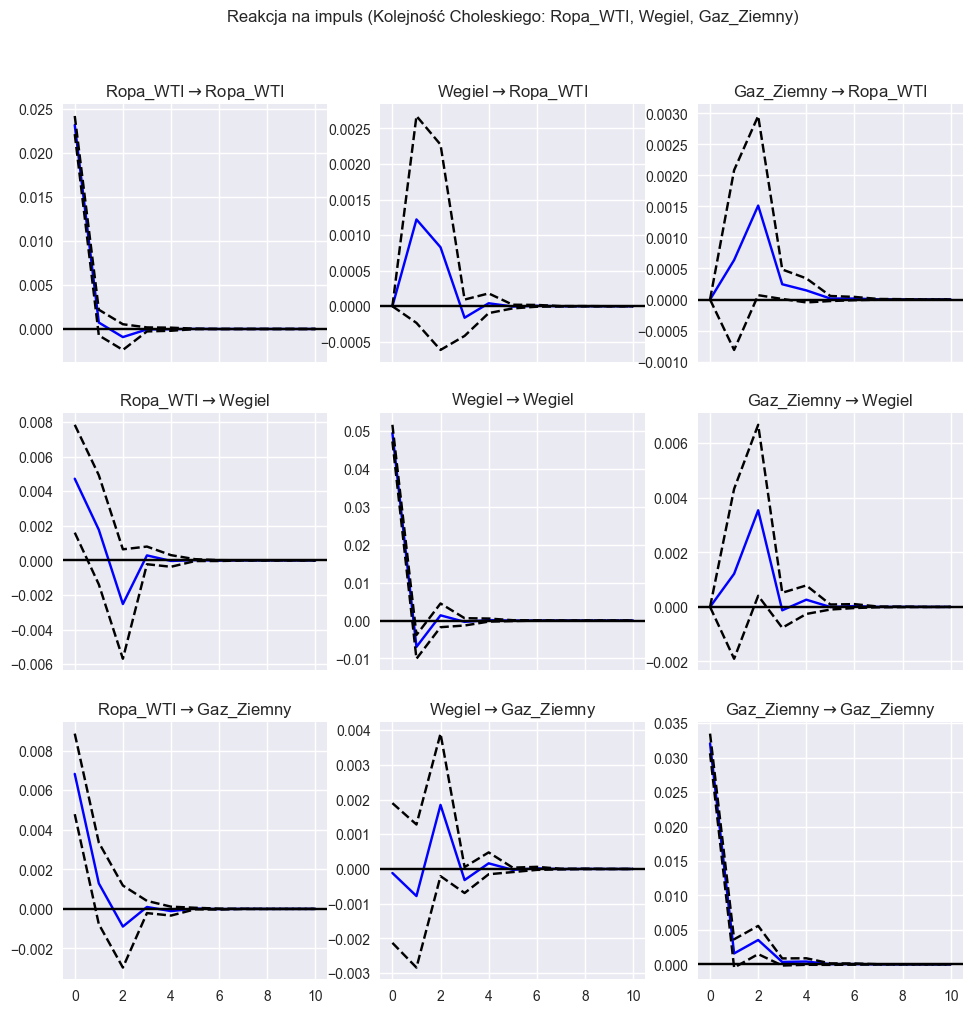

In [ ]:
print("\nFUNKCJE ODPOWIEDZI NA IMPULS (IRF)")
var_names = df_ret.columns.tolist()
causality_score = {name: 0 for name in var_names}

cholesky_order = ['Ropa_WTI', 'Wegiel','Gaz_Ziemny']

print(f"Kolejność do IRF: {' -> '.join(cholesky_order)}")

df_ordered = df_ret[cholesky_order]

# Budujemy nowy model na posortowanych danych
model_irf = VAR(df_ordered)
# Używamy tej samej liczby opóźnień co wcześniej (np. 4)
results_irf = model_irf.fit(2)

# 4. Generowanie i rysowanie IRF
irf = results_irf.irf(10)

plt.figure(figsize=(10, 10))
# Rysowanie z przedziałami ufności liczonymi metodą Monte Carlo (bardziej odporne)
irf.plot(orth=True, signif=0.05, repl=1000, seed=42)

plt.suptitle(f"Reakcja na impuls (Kolejność Choleskiego: {', '.join(cholesky_order)})", y=1.02)
plt.show()


=== DEKOMPOZYCJA WARIANCJI (FEVD) ===
FEVD for Ropa_WTI
     Ropa_WTI    Wegiel  Gaz_Ziemny
0    1.000000  0.000000    0.000000
1    0.996476  0.002771    0.000753
2    0.990998  0.004022    0.004980
3    0.990840  0.004069    0.005091
4    0.990797  0.004072    0.005131
5    0.990796  0.004072    0.005131
6    0.990796  0.004072    0.005132
7    0.990796  0.004072    0.005132
8    0.990796  0.004072    0.005132
9    0.990796  0.004072    0.005132

FEVD for Wegiel
     Ropa_WTI    Wegiel  Gaz_Ziemny
0    0.009012  0.990988    0.000000
1    0.010063  0.989354    0.000583
2    0.012476  0.982018    0.005506
3    0.012507  0.981981    0.005512
4    0.012507  0.981953    0.005539
5    0.012508  0.981953    0.005539
6    0.012508  0.981953    0.005540
7    0.012508  0.981953    0.005540
8    0.012508  0.981953    0.005540
9    0.012508  0.981953    0.005540

FEVD for Gaz_Ziemny
     Ropa_WTI    Wegiel  Gaz_Ziemny
0    0.043350  0.000013    0.956637
1    0.044700  0.000577    0.954723
2    

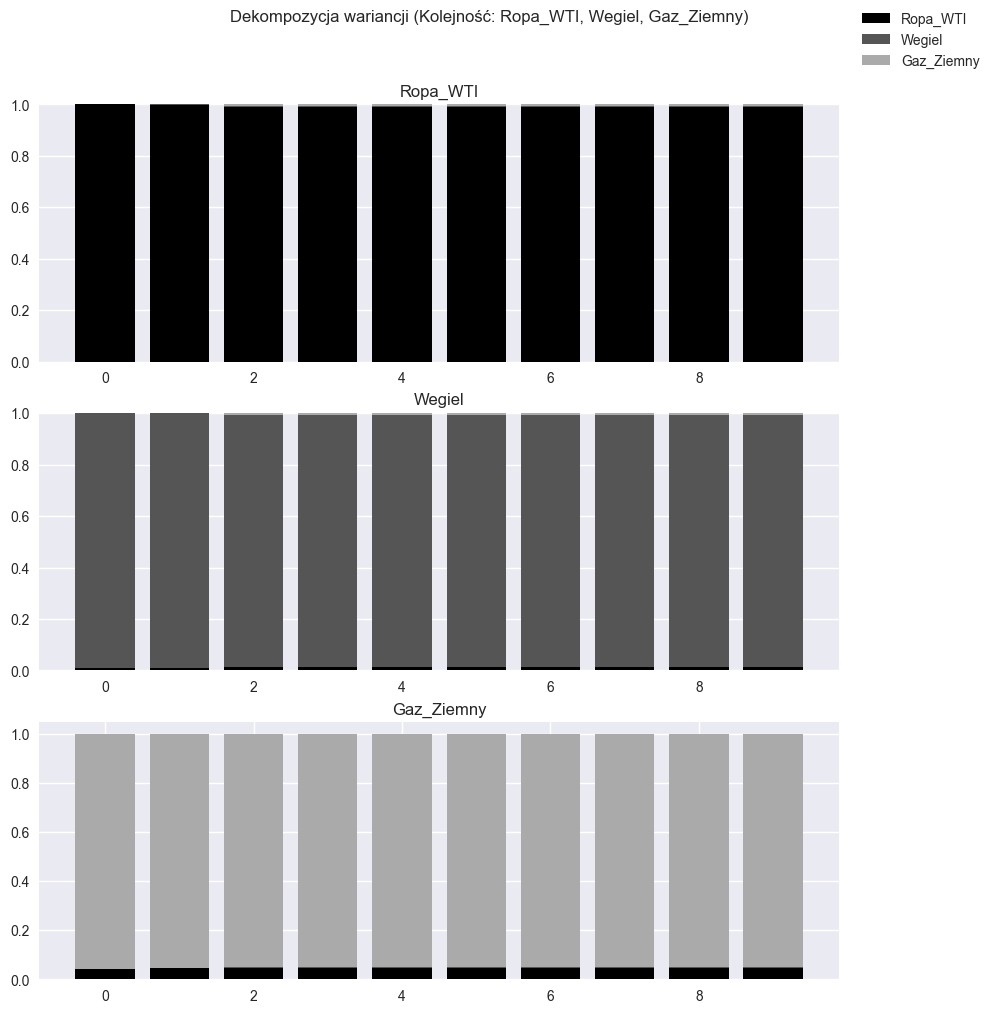

In [ ]:
print("\n=== DEKOMPOZYCJA WARIANCJI (FEVD) ===")
fevd = results_irf.fevd(10)
print(fevd.summary())
fevd.plot()
plt.suptitle(f"Dekompozycja wariancji (Kolejność: {', '.join(cholesky_order)})", y=1.02)
plt.show()